# Challenge 2: An empirical study on the learnability of functions by *NNs*

Numerous classes and functions are stored in the `models.py` file and `utils.py` file. The `models.py` file contains the neural network models and the `utils.py` file contains the functions that will be used in this notebook.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Custom modules
from utils import *
from models import *


SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## **Exercise A**: The effect of *under* and *over* parameterisation in the *Teacher/Student* setup

### 1. Teacher model

We begin by instantiating the teacher model, with the weights initialized at random according to the standard normal distribution.

In [34]:
teacher = Teacher().to(device)
teacher.init_weights()

# Put the model in evaluation mode
teacher.eval()

Teacher(
  (activation): ReLU()
  (net): Sequential(
    (0): Linear(in_features=100, out_features=75, bias=True)
    (1): ReLU()
    (2): Linear(in_features=75, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=25, bias=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=1, bias=True)
  )
)

### 2. Test set

We generate the test set according to the given description.

In [35]:
# The covariates are random uniform in [0,2] of 100 dimensions
dataset_test = generate_test_dataset(60000, teacher, device)
test_loader = DataLoader(dataset_test, batch_size=1024, shuffle=False)

### 3+4. Student models

We instantiate and train the three different student models

In [36]:
# Training parameters
n_steps = 1000
test_every = 50

- *Under*-parameterized student model

In [37]:
student_U = StudentU().to(device)
student_U.init_weights()

print_nparams(student_U)

Number of parameters for StudentU: 1021


In [38]:
losses_train, losses_test = train(
    student = student_U,
    teacher = teacher,
    test_loader=test_loader,
    lr = 1e-1,
    n_steps=1000,
    test_every=50,
    device=device,
)

df_Student_U = pd.DataFrame({
    "train_loss": losses_train,
    "test_loss": interpolate_test_losses(losses_test, n_steps, test_every)
})

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

- *Equally*-parametrized student model

In [39]:
student_E = StudentE().to(device)
student_E.init_weights()

print_nparams(student_E)

Number of parameters for StudentE: 12676


In [40]:
losses_train, losses_test = train(
    student = student_E,
    teacher = teacher,
    test_loader=test_loader,
    lr = 1e-1,
    n_steps=1000,
    test_every=50,
    device=device,
)

df_Student_E = pd.DataFrame({
    "train_loss": losses_train,
    "test_loss": interpolate_test_losses(losses_test, n_steps, test_every)
})

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

*Over*-Parameterized student model

In [41]:
student_O = StudentO().to(device)
student_O.init_weights()

print_nparams(student_O)

Number of parameters for StudentO: 120801


In [42]:
losses_train, losses_test = train(
    student = student_O,
    teacher = teacher,
    test_loader=test_loader,
    lr = 1e-1,
    n_steps=1000,
    test_every=50,
    device=device,
)

df_Student_O = pd.DataFrame({
    "train_loss": losses_train,
    "test_loss": interpolate_test_losses(losses_test, n_steps, test_every)
})

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

#### Training results

Hereafter we plot the loss evolution during training for both the training set and the test set.

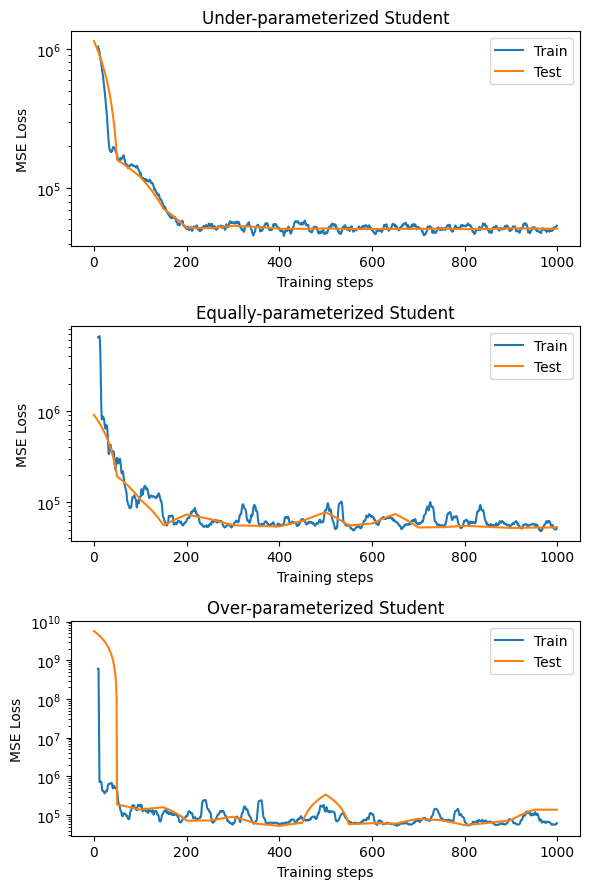

In [43]:
fig, ax = plt.subplots(3, 1, figsize=(6, 9))

# Under parameterized student
ax[0].plot(df_Student_U.train_loss.rolling(10).mean(), label="Train")
ax[0].plot(df_Student_U.test_loss, label="Test")
ax[0].set_title("Under-parameterized Student")
ax[0].set_xlabel("Training steps")
ax[0].set_ylabel("MSE Loss")
ax[0].set_yscale('log')
ax[0].legend()

# Equally parameterized student
ax[1].plot(df_Student_E.train_loss.rolling(10).mean(), label="Train")
ax[1].plot(df_Student_E.test_loss, label="Test")
ax[1].set_title("Equally-parameterized Student")
ax[1].set_xlabel("Training steps")
ax[1].set_ylabel("MSE Loss")
ax[1].set_yscale('log')
ax[1].legend()

# Over parameterized student
ax[2].plot(df_Student_O.train_loss.rolling(10).mean(), label="Train")
ax[2].plot(df_Student_O.test_loss, label="Test")
ax[2].set_title("Over-parameterized Student")
ax[2].set_xlabel("Training steps")
ax[2].set_ylabel("MSE Loss")
ax[2].set_yscale('log')
ax[2].legend()

plt.tight_layout()
plt.show()

### 5. Final test

We test the models once more on the test set and plot the results.

In [44]:
# Evaluate the models on the test set
df_results = []

for student in [StudentU, StudentE, StudentO]:
    student = student().to(device)
    student.init_weights()
    
    with torch.no_grad():
        for i, (X, y) in enumerate(test_loader):
            y_pred = student(X)
            mse = nn.MSELoss()(y_pred, y)
            df_results.append({
                "student": student.__class__.__name__,
                "mse": mse.item()
            })
            
df_results = pd.DataFrame(df_results)

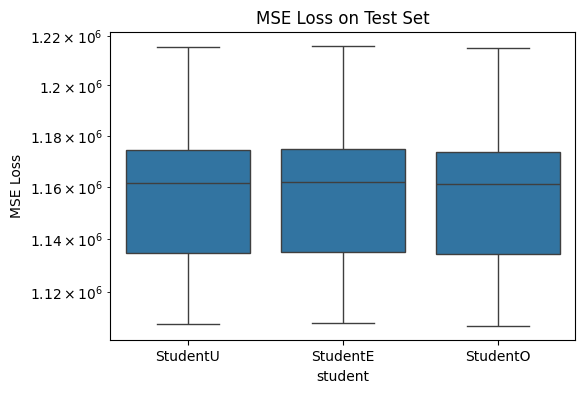

In [45]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_results, x="student", y="mse")
plt.yscale('log')
plt.ylabel("MSE Loss")
plt.title("MSE Loss on Test Set")
plt.show()

In [46]:
df_results.groupby("student").mse.describe().round()

,count,mean,std,min,25%,50%,75%,max
student,,,,,,,,
StudentE,59.0,1157806.0,26499.0,1108358.0,1135077.0,1161994.0,1174634.0,1215913.0
StudentO,59.0,1156826.0,26487.0,1107415.0,1134093.0,1161019.0,1173656.0,1214911.0
StudentU,59.0,1157336.0,26479.0,1107950.0,1134627.0,1161585.0,1174126.0,1215457.0


#### Weights distribution

In addition we analyze the distribution of the weights of the models.

In [51]:
weights_U = [ w.cpu().detach().numpy() for w in student_U.parameters() ]
weights_E = [ w.cpu().detach().numpy() for w in student_E.parameters() ]
weights_O = [ w.cpu().detach().numpy() for w in student_O.parameters() ]

global_weights_U = np.concatenate([ w.flatten() for w in weights_U ])
global_weights_E = np.concatenate([ w.flatten() for w in weights_E ])
global_weights_O = np.concatenate([ w.flatten() for w in weights_O ])

Global analisys

In [55]:
table = [
    ["Under parametrized student", global_weights_U.mean(), global_weights_U.std()],
    ["Equally parametrized student", global_weights_E.mean(), global_weights_E.std()],
    ["Over parametrized student", global_weights_O.mean(), global_weights_O.std()],
]
print(tabulate(table, headers=["Student", "Mean", "Std"], tablefmt="fancy_grid", floatfmt=".2f"))

╒══════════════════════════════╤════════╤═══════╕
│ Student                      │   Mean │   Std │
╞══════════════════════════════╪════════╪═══════╡
│ Under parametrized student   │  -0.46 │  1.91 │
├──────────────────────────────┼────────┼───────┤
│ Equally parametrized student │  -0.34 │  0.72 │
├──────────────────────────────┼────────┼───────┤
│ Over parametrized student    │  -0.24 │  0.52 │
╘══════════════════════════════╧════════╧═══════╛


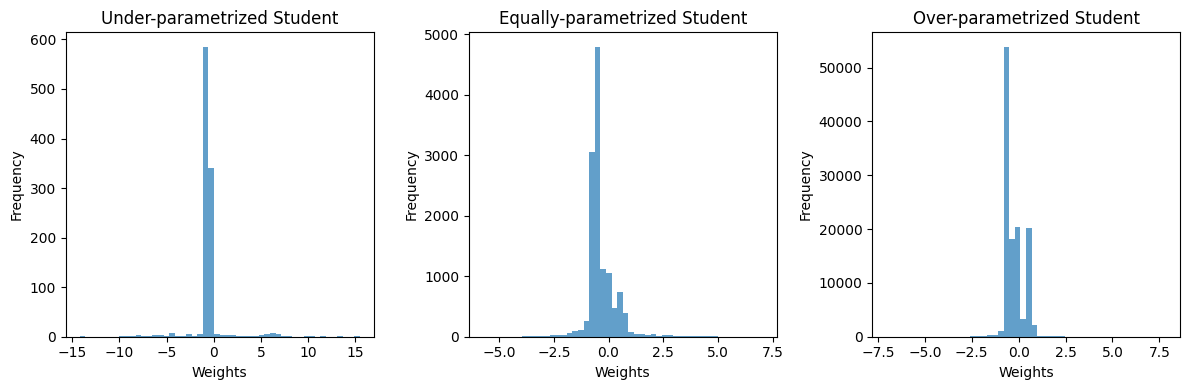

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# Under parametrized student
ax[0].hist(global_weights_U, bins=50, alpha=0.7)
ax[0].set_title("Under-parametrized Student")
ax[0].set_xlabel("Weights")
ax[0].set_ylabel("Frequency")
# Equally parametrized student
ax[1].hist(global_weights_E, bins=50, alpha=0.7)
ax[1].set_title("Equally-parametrized Student")
ax[1].set_xlabel("Weights")
ax[1].set_ylabel("Frequency")
# Over parametrized student
ax[2].hist(global_weights_O, bins=50, alpha=0.7)
ax[2].set_title("Over-parametrized Student")
ax[2].set_xlabel("Weights")
ax[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()